In [43]:
import pandas as pd
import numpy as np
import pyfixest as pf
import scipy
from scipy import stats
import altair as alt
import statsmodels.formula.api as smf

In [44]:
# Read state policy data
df = pd.read_csv('data/cspp_data_2025-11-20.csv')
df.columns
df

,year,st,stateno,state,state_fips,state_icpsr,avgec_low,avgec_mid,avgec_high,avgsoc_low,...,sqli,health_rank,infconsent,w_ec_access,solaw,vaaban,frps,drugs_medical_marijuana,gambling_lottery_adoption,guncontrol_assaultweapon_ban
0,1960,AK,2.0,Alaska,2,81,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,1961,AK,2.0,Alaska,2,81,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,1962,AK,2.0,Alaska,2,81,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,1963,AK,2.0,Alaska,2,81,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,1964,AK,2.0,Alaska,2,81,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,2016,WY,50.0,Wyoming,56,68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3107,2017,WY,50.0,Wyoming,56,68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3108,2018,WY,50.0,Wyoming,56,68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3109,2019,WY,50.0,Wyoming,56,68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Read NEA teacher salary data
salaries_df_wide = pd.read_csv('data/teacher_salaries.csv')
salaries_df = pd.melt(salaries_df_wide, id_vars = ['State'], var_name = 'Year', value_name = 'Salary')
salaries_df.rename(columns = {'State': 'state', 'Year': 'year', 'Salary': 'salary'}, inplace = True)

salaries_df['year'] = salaries_df['year'].astype(int)
salaries_df['salary'] = salaries_df['salary'].replace({',': ''}, regex=True).astype(int)

salaries_df

,state,year,salary
0,United States,1990,31367
1,Alabama,1990,24828
2,Alaska,1990,43153
3,Arizona,1990,29402
4,Arkansas,1990,22352
...,...,...,...
1607,Virginia,2020,57665
1608,Washington,2020,76743
1609,West Virginia,2020,50238
1610,Wisconsin,2020,59431


In [46]:
df_filtered = df[['year', 'st', 'state', 'agencyfeesprohibited']]

# Filter between 1990 and 2017 
df_filtered = df_filtered[(df_filtered['year'] >= 1990) & (df_filtered['year'] <= 2017)]

df_filtered

,year,st,state,agencyfeesprohibited
30,1990,AK,Alaska,0.0
31,1991,AK,Alaska,0.0
32,1992,AK,Alaska,0.0
33,1993,AK,Alaska,0.0
34,1994,AK,Alaska,0.0
...,...,...,...,...
3103,2013,WY,Wyoming,1.0
3104,2014,WY,Wyoming,1.0
3105,2015,WY,Wyoming,1.0
3106,2016,WY,Wyoming,1.0


In [47]:
df_merged = pd.merge(df_filtered, salaries_df, on = ['state', 'year'], how = 'left')

# Drop District of Columbia
df_merged = df_merged[df_merged['state'] != 'District of Columbia']

# Adjust variable types
df_merged['agencyfeesprohibited'] = df_merged['agencyfeesprohibited'].astype(int)
df_merged["state"] = df_merged["state"].astype("string")
df_merged["st"] = df_merged["st"].astype("string")

# Identify states that ever had a 1 under 'agencyfeesprohibited' i.e., ever had a RTW law pass
states_with_fees_prohibited = df_merged[df_merged['agencyfeesprohibited'] == 1]['st'].unique()

# Exclude states that ever had RTW except for Wisconsin (our sole treatment)
df = df_merged[~((df_merged['st'].isin(states_with_fees_prohibited)) & (df_merged['st'] != 'WI'))]

df

,year,st,state,agencyfeesprohibited,salary
0,1990,AK,Alaska,0,43153
1,1991,AK,Alaska,0,43427
2,1992,AK,Alaska,0,44661
3,1993,AK,Alaska,0,46701
4,1994,AK,Alaska,0,47512
...,...,...,...,...,...
1367,2013,WI,Wisconsin,1,53797
1368,2014,WI,Wisconsin,1,53679
1369,2015,WI,Wisconsin,1,52264
1370,2016,WI,Wisconsin,1,54115


In [48]:
plot = alt.Chart(
    df_merged, 
    title = alt.Title(
        'Title', 
        subtitle = 'Subtitle'
        )).mark_line().encode(
    alt.X('year:Q'), 
    alt.Y('salary:Q').scale(zero=False), 
    alt.Color('state:N'))

vline_WI = alt.Chart(pd.DataFrame({"year":[2011]})).mark_rule(color="red").encode(x='year:Q')

plot + vline_WI 

alt.LayerChart(...)

In [49]:
df["wisconsin"] = (df["st"] == 'WI')
df["after_treatment"] = df["year"] > 2011

In [50]:
import random
from scpi_pkg.scdata import scdata
from scpi_pkg.scest import scest
from scpi_pkg.scplot import scplot
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["salary_scaled"] = scaler.fit_transform(df[["salary"]])

scdf = scdata(df = df, id_var= "state", time_var="year", outcome_var="salary_scaled",
              period_pre=df.query("not after_treatment").year.unique(),
              period_post=df.query("after_treatment").year.unique(),
              unit_tr='Wisconsin',
              unit_co=df.query("not wisconsin").state.unique(),
              features=["salary_scaled"],
              cov_adj=None, 
              cointegrated_data=True,
              constant=False)


-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                           simplex
Constraint Size (Q):                                             1
Treated Unit:                                            Wisconsin
Size of the donor pool:                                         23
Features                                                         1
Pre-treatment period                                     1990-2011
Pre-treatment periods used in estimation:                       22
Covariates used for adjustment:                                  0

Synthetic Control Estimation - Results

Active donors: 7

Coefficients:
                            Weights
Treated Unit Donor                 
Wisconsin    Alaska           0.181
             California       0.000
             Colorado         0.000
             Connecticut      0.000
             Delaware         0.000
             Hawa

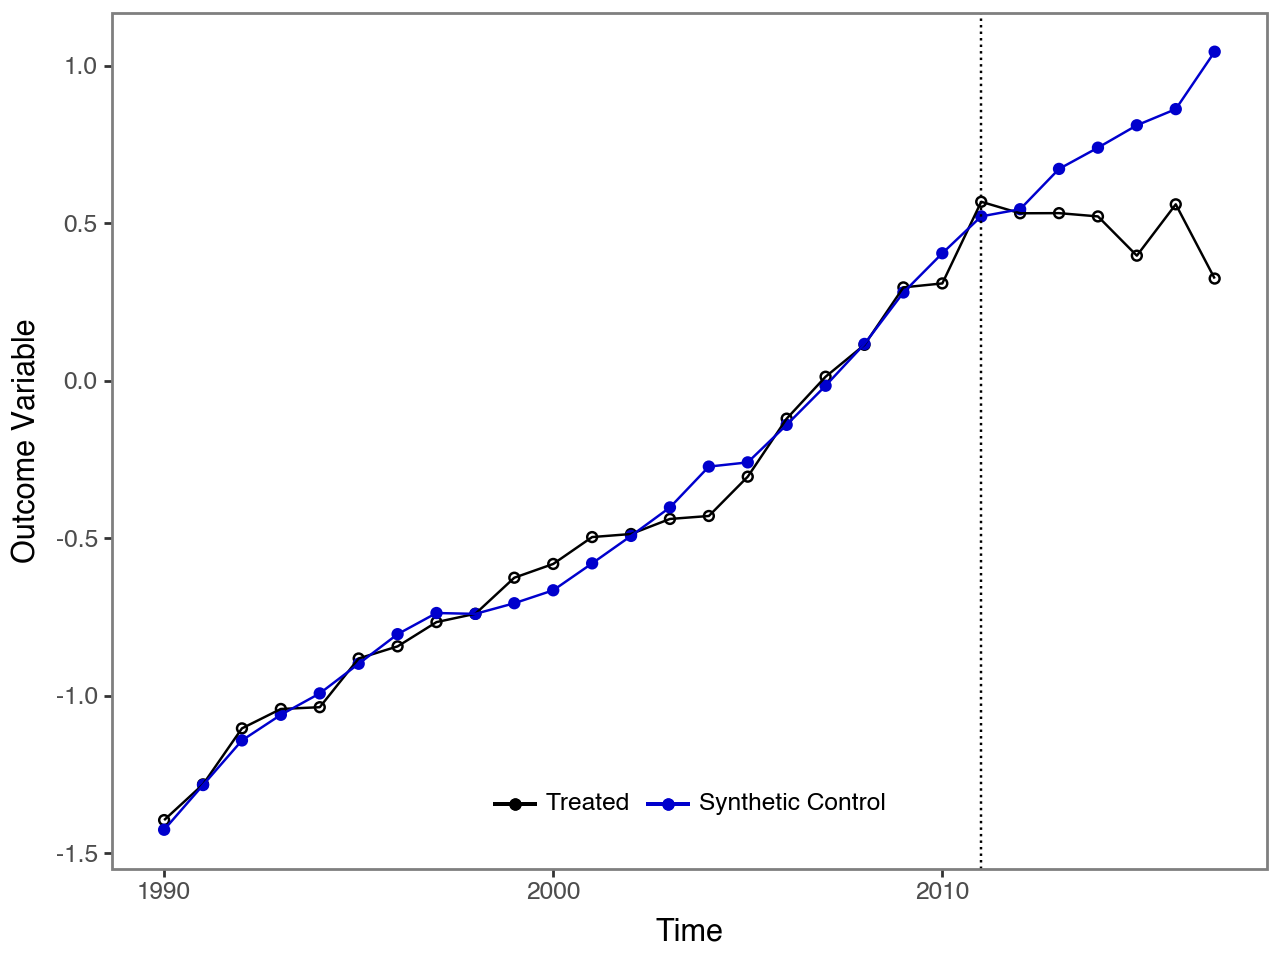

In [51]:
est_si = scest(scdf, w_constr={'name': "simplex"})
print(est_si)
scplot(est_si)

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

terations completed (10%)
terations completed (20%)
terations completed (30%)
terations completed (40%)
iterations completed (50%)
iterations completed (60%)
iterations completed (70%)
iterations completed (80%)
iterations completed (90%)


/Users/rico/Documents/526-project/.venv/lib/python3.13/site-packages/plotnine/layer.py:374: PlotnineWarning: geom_errorbar : Removed 22 rows containing missing values.


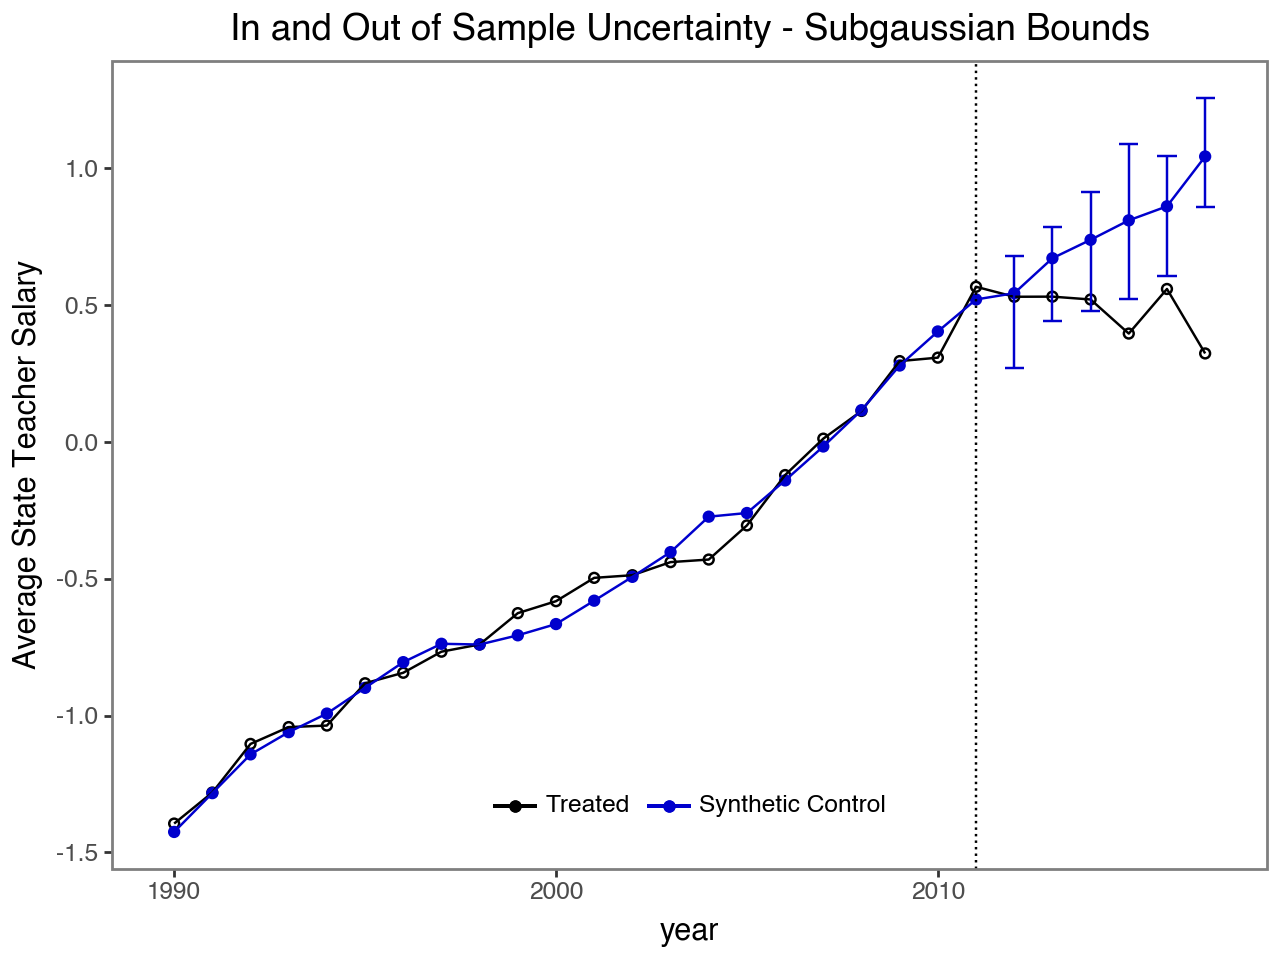

In [52]:
from scpi_pkg.scpi import scpi

w_constr = {'name': 'simplex', 'Q': 1}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 200
cores = 1

random.seed(1)
result = scpi(scdf, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
              e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
              u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)
scplot(result, e_out=True, x_lab="year", y_lab="Average State Teacher Salary")

In [53]:
sc = np.concatenate([est_si.Y_pre_fit, est_si.Y_post_fit]).reshape(-1, 1).flatten()

sc_original = scaler.inverse_transform(
    np.concatenate([est_si.Y_pre_fit, est_si.Y_post_fit]).reshape(-1, 1)).flatten()

synth_results = pd.DataFrame({
    'year': list(est_si.period_pre) + list(est_si.period_post),
    'synthetic_control': sc_original, 
    'synthetic_control_scaled': sc})

df = pd.merge(df, synth_results, on = ['year'], how = 'left')

In [54]:
# Calculate treatment effects
df['te'] = df['salary'] - df['synthetic_control']

df_te_wi = df[df['st'] == 'WI']
df_te_wi = df_te_wi[df_te_wi['after_treatment'] == True]
df_te_wi = df_te_wi[['year', 'state', 'salary', 'synthetic_control', 'te']]
df_te_wi

,year,state,salary,synthetic_control,te
666,2012,Wisconsin,53792,53938.546452,-146.546452
667,2013,Wisconsin,53797,55391.564265,-1594.564265
668,2014,Wisconsin,53679,56156.723469,-2477.723469
669,2015,Wisconsin,52264,56964.046714,-4700.046714
670,2016,Wisconsin,54115,57546.301681,-3431.301681
671,2017,Wisconsin,51439,59615.684558,-8176.684558


In [ ]:
from sklearn.metrics import mean_squared_error

df_before_treatment = df[df['after_treatment'] == False]

state_mse = df_before_treatment.groupby('state').apply(lambda group: mean_squared_error(group['salary'], group['synthetic_control'])).reset_index(name='MSE')
state_mse
state_mse['RMSE'] = np.sqrt(state_mse['MSE'])

states_filtered = state_mse[state_mse['RMSE'] < 5000]['state'].tolist() # Picked 5000 somewhat arbitrarily
states_filtered

['Colorado',
 'Delaware',
 'Hawaii',
 'Minnesota',
 'New Hampshire',
 'Ohio',
 'Oregon',
 'Vermont',
 'Washington',
 'Wisconsin']

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                           simplex
Constraint Size (Q):                                             1
Treated Unit:                                            Wisconsin
Size of the donor pool:                                          9
Features                                                         1
Pre-treatment period                                     1990-2011
Pre-treatment periods used in estimation:                       22
Covariates used for adjustment:                                  0

Synthetic Control Estimation - Results

Active donors: 4

Coefficients:
                            Weights
Treated Unit Donor                 
Wisconsin    Colorado         0.000
             Delaware         0.184
             Hawaii           0.000
             Minnesota        0.000
             New Hampshire    0.000
             Ohio

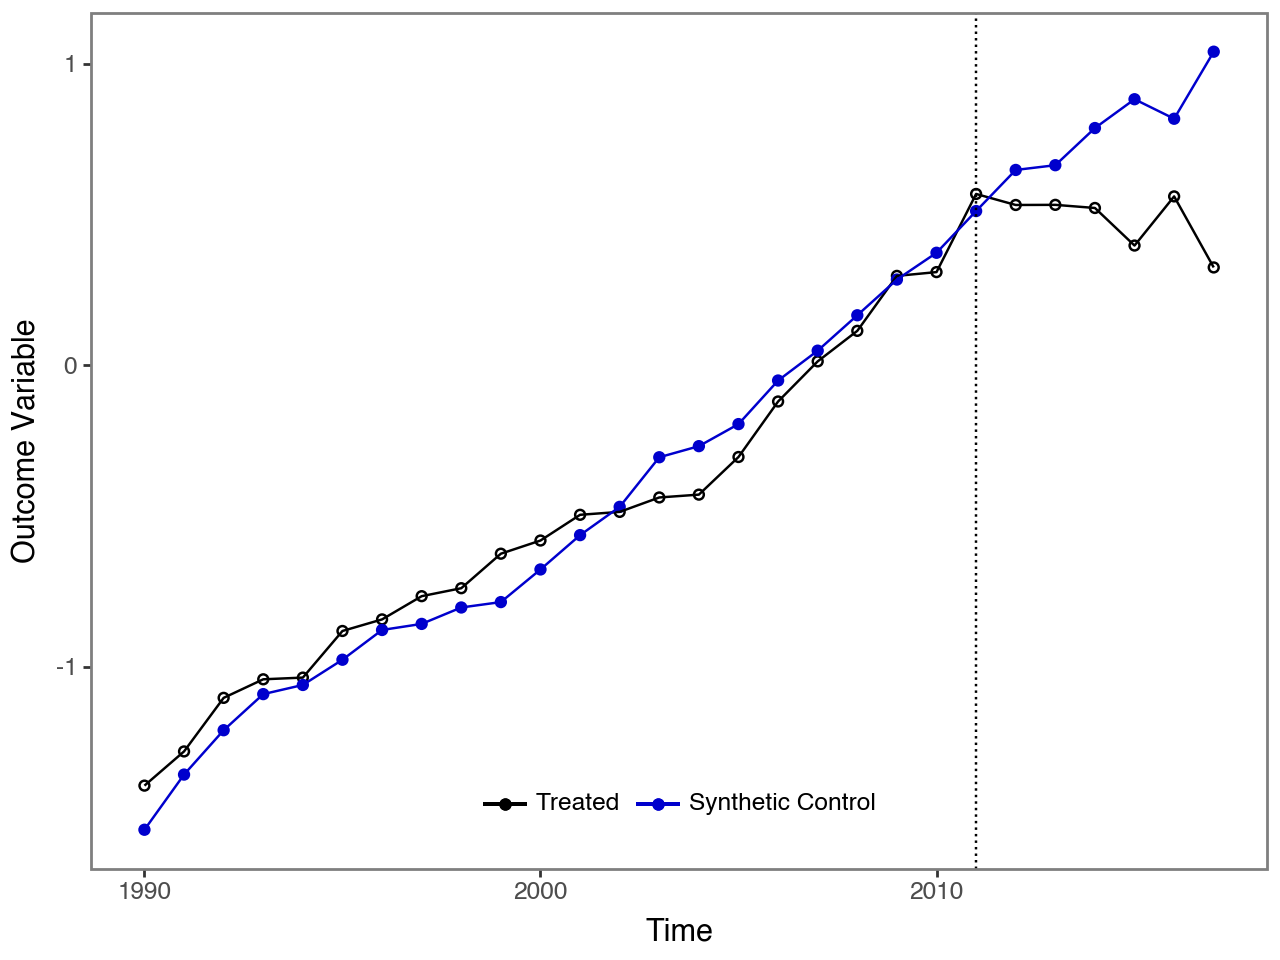

In [56]:
df2 = df[df['state'].isin(states_filtered)]

scdf2 = scdata(df = df2, id_var="state", time_var="year", outcome_var="salary_scaled",
              period_pre=df2.query("not after_treatment").year.unique(),
              period_post=df2.query("after_treatment").year.unique(),
              unit_tr='Wisconsin',
              unit_co=df2.query("not wisconsin").state.unique(),
              features=["salary_scaled"],
              cov_adj=None, 
              cointegrated_data=True,
              constant=False)

est_si2 = scest(scdf2, w_constr={'name': "simplex"})
print(est_si2)
scplot(est_si2)

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty

terations completed (10%)
terations completed (20%)
terations completed (30%)
terations completed (40%)
iterations completed (50%)
iterations completed (60%)
iterations completed (70%)
iterations completed (80%)
iterations completed (90%)


/Users/rico/Documents/526-project/.venv/lib/python3.13/site-packages/plotnine/layer.py:374: PlotnineWarning: geom_errorbar : Removed 22 rows containing missing values.


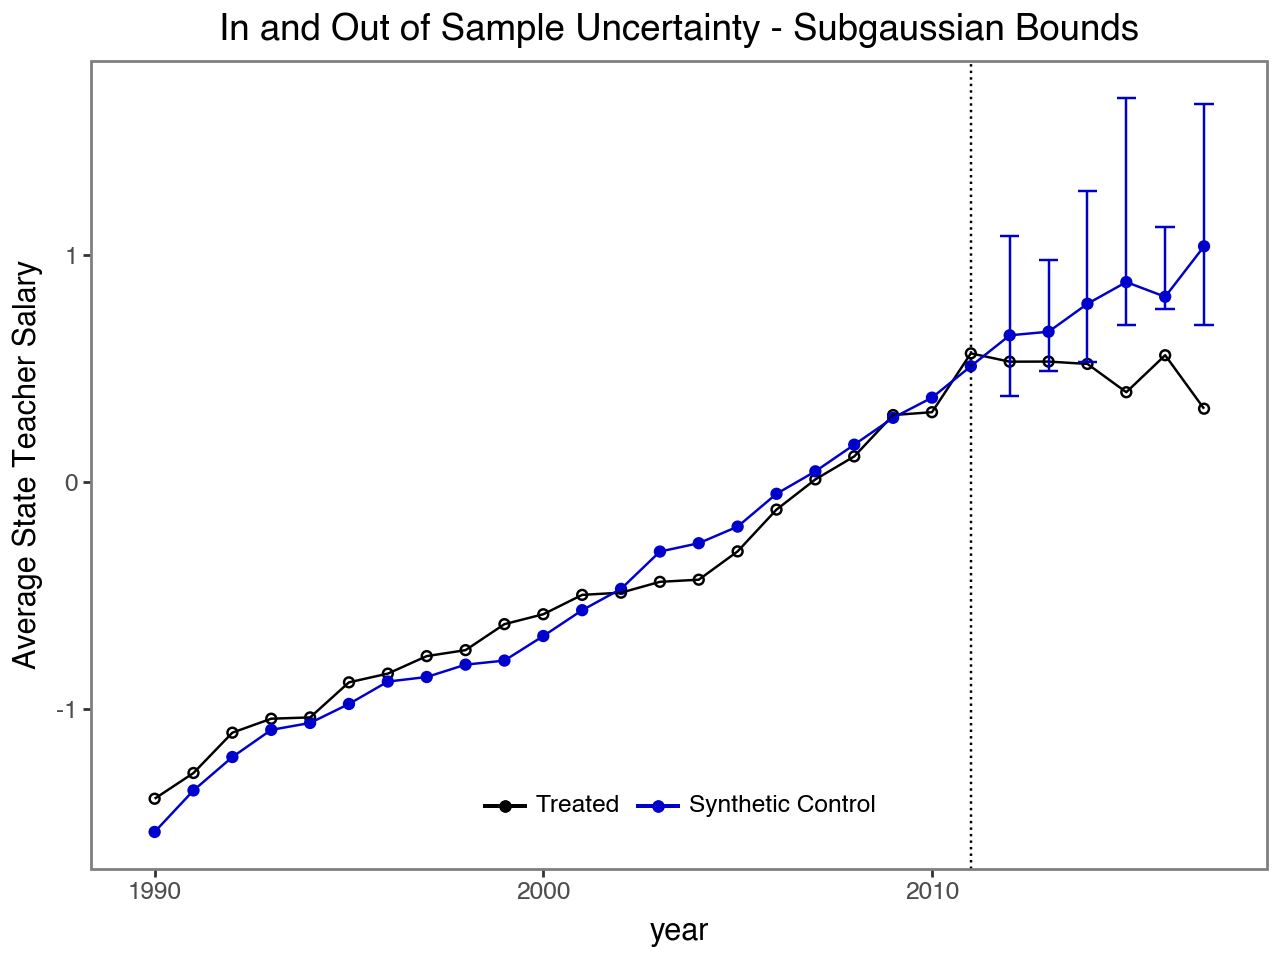

In [57]:
from scpi_pkg.scpi import scpi

random.seed(1)
result2 = scpi(scdf2, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
              e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
              u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)
scplot(result2, e_out=True, x_lab="year", y_lab="Average State Teacher Salary")